In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
import json
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_score


In [2]:
gt_csv_path = "/home/lxj/project/surgplan/LUO/test_only/TriDet/ground_truth_cataracts.csv"
pred_csv_path = "/home/lxj/project/surgplan/LUO/test_only/TriDet/prediction_cataracts.csv"

In [3]:
gt_df = pd.read_csv(gt_csv_path,usecols=["video-id","t-start","t-end","label"])
pred_df = pd.read_csv(pred_csv_path,usecols=["video-id","t-start","t-end","label","score"])
with open("//home/lxj/project/surgplan/LUO/test_only/TriDet/data_cataracts.json","r") as f:
    gt_json = json.load(f)

In [4]:
pred_df = pred_df.sort_values(by=["video-id","score"])

In [5]:
threshold_list = np.linspace(0.1,0.3,11)
threshold_list

array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ])

In [6]:
#pred_df = pred_df[pred_df["score"]>0.15]

In [6]:
def calculate_acc(pred_df,gt_df):
    df_gt= pd.DataFrame(columns=["video_id","gt_labels"])
    for k,v in gt_json.items():
        if "train" in k:
            continue
        dur = v["last_time"]
        video_name = k.split(".")[0]
        gt_labels = [0 for i in range(int(np.round(dur)))]
        video_id = [k for i in range(int(np.round(dur)))]
        df = pd.DataFrame(columns=["video_id","gt_labels"])
        df["video_id"] = video_id
        df["gt_labels"] = gt_labels
        subset = gt_df[gt_df["video-id"]==video_name]
        
        for index in subset.index:
            start = int(np.round(subset.loc[index]["t-start"]))
            end = int(np.round(subset.loc[index]["t-end"]))
            label = subset.loc[index]["label"]
            for i in range(start,end+1):
                df.loc[i,"gt_labels"] = label+1
        
        df_gt = pd.concat([df_gt,df],ignore_index=True)    
    df_pred = pd.DataFrame(columns=["video_id","pred_labels"])


    for k,v in gt_json.items():
        if "train" in k:
            continue
        video_name = k.split(".")[0]
        dur = v["last_time"]
        gt_labels = [0 for i in range(int(np.round(dur)))]
        video_id = [k for i in range(int(np.round(dur)))]
        df = pd.DataFrame(columns=["video_id","pred_labels"])
        df["video_id"] = video_id
        df["pred_labels"] = gt_labels
        subset = pred_df[pred_df["video-id"]==video_name]
        
        for index in subset.index:
            start = int(np.round(subset.loc[index]["t-start"]))
            end = int(np.round(subset.loc[index]["t-end"]))
            label = subset.loc[index]["label"]
            for i in range(start,end+1):
                if i>=len(df):
                    continue
                df.loc[i,"pred_labels"] = label+1
        #print(df)
        df_pred = pd.concat([df_pred,df],ignore_index=True)

    df_all =pd.concat([df_gt,df_pred["pred_labels"]],axis=1)
    acc = accuracy_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list())
    f1 = f1_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list(),average="weighted")
    recall = recall_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list(),average="weighted")
    precision = precision_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list(),average="weighted")
    jaccard = jaccard_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list(),average="weighted")

    df_pred.to_csv("df_pred.csv",index=False)
    df_gt.to_csv("df_gt.csv",index=False)
    print("accuracy under the threshold : ", acc,end="     ")
    print("f1 score under the threshold : ", f1,end="     ")
    print("precision score under the threshold : ", precision,end="     ")
    print("recall score under the threshold : ", recall)
    print("jaccard score under the threshold : ", jaccard)

In [242]:
print(plt.cm.cmap_d.keys())

KeysView(<matplotlib.cm._DeprecatedCmapDictWrapper object at 0x7f6d6abf8910>)


In [7]:
pred_df_threshold = pred_df[pred_df["score"]>0.20]
calculate_acc(pred_df_threshold)

accuracy under the threshold :  0.8438310005184033     f1 score under the threshold :  0.8400354694376387     precision score under the threshold :  0.8425916033868036     recall score under the threshold :  0.8438310005184033
jaccard score under the threshold :  0.733720921448908


/home/lxj/anaconda3/envs/surgplan/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
num_to_label = { 
0:"background",
1:'Toric Marking',
2:'Implant Ejection', 
3:'Incision', 
4:'Viscodilatation', 
5:'Capsulorhexis', 
6:'Hydrodissetion',
7:'Nucleus Breaking', 
8:'Phacoemulsification', 
9:'Vitrectomy', 
10:'Irrigation/Aspiration', 
11:'Preparing Implant',
12:'Manual Aspiration', 
13:'Implantation', 
14:'Positioning', 
15:'OVD Aspiration', 
16:'Suturing', 
17:'Sealing Control',
18:'Wound Hydratation'}

In [243]:
from __future__ import print_function
from __future__ import division
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import *
from PIL import Image
from collections import OrderedDict

import csv


def _barcode(gt, predict_phasenet, predict_trans, slowfast,predict_ours, save_file=None,color_map = plt.cm.tab20):
    color_map = color_map # 色板
    barprops = dict(aspect='auto', cmap=color_map,
                    interpolation='nearest', vmin=0, vmax=20)
    num_to_label = { 
        0:"background",
        1:'Toric Marking',
        2:'Implant Ejection', 
        3:'Incision', 
        4:'Viscodilatation', 
        5:'Capsulorhexis', 
        6:'Hydrodissetion',
        7:'Nucleus Breaking', 
        8:'Phacoemulsification', 
        9:'Vitrectomy', 
        10:'Irrigation/Aspiration', 
        11:'Preparing Implant',
        12:'Manual Aspiration', 
        13:'Implantation', 
        14:'Positioning', 
        15:'OVD Aspiration', 
        16:'Suturing', 
        17:'Sealing Control',
        18:'Wound Hydratation'}
    #plt.axis('off')
    fig = plt.figure(figsize=(15, 10))
    # a horizontal barcode
    if gt is not None:
        ax1 = fig.add_axes([0, 0.32, 1, 0.1])
        #ax1.set_title('Ground Truth',fontsize=34)
        ax1.set_xticks([])
        ax1.set_yticks([])
        #labels = sorted(df_gt["gt_labels"].unique())  
        #patches = [mpatches.Patch(color=color_map(i)) for i in labels]
        ax1.imshow([gt], **barprops)

    if predict_phasenet is not None:
        ax2 = fig.add_axes([0, 0.80, 1, 0.1])
        #ax2.set_title('TeCNO',fontsize=34)
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.imshow([predict_phasenet], **barprops)


    #80 68 56 44
    if predict_trans is not None:
        ax2 = fig.add_axes([0, 0.68, 1, 0.1])
        #ax2.set_title('SVRCN',fontsize=34)
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.imshow([predict_trans], **barprops)
    
    if slowfast is not None:
        ax2 = fig.add_axes([0, 0.56, 1, 0.1])
        #ax2.set_title('SVRCN',fontsize=34)
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.imshow([slowfast], **barprops)

    if predict_ours is not None:
        ax2 = fig.add_axes([0, 0.44, 1, 0.1])
        #ax2.set_title('Predicted-Ours',fontsize=34)
        ax2.set_xticks([])
        ax2.set_yticks([])
        #ax1.legend(labels = [num_to_label[i] for i in labels],handles=patches, loc='lower left', bbox_to_anchor=(1, 0))

        ax2.imshow([predict_ours], **barprops)



    if save_file is not None:
        fig.savefig(save_file, dpi=400)
    else:
        plt.show()
        
    plt.close(fig)


In [254]:
df_pred = pd.read_csv("/home/lxj/project/surgplan/LUO/test_only/TriDet/df_pred.csv")
df_gt = pd.read_csv("/home/lxj/project/surgplan/LUO/test_only/TriDet/df_gt.csv")

df_pred = df_pred[df_pred["video_id"]=="test23.mp4"]
df_gt = df_gt[df_gt["video_id"]=="test23.mp4"]


In [214]:
trans_result_2 = trans_pred[12304:12840]

In [215]:
tecno_result_2 = tecno_pred[12304:12840]

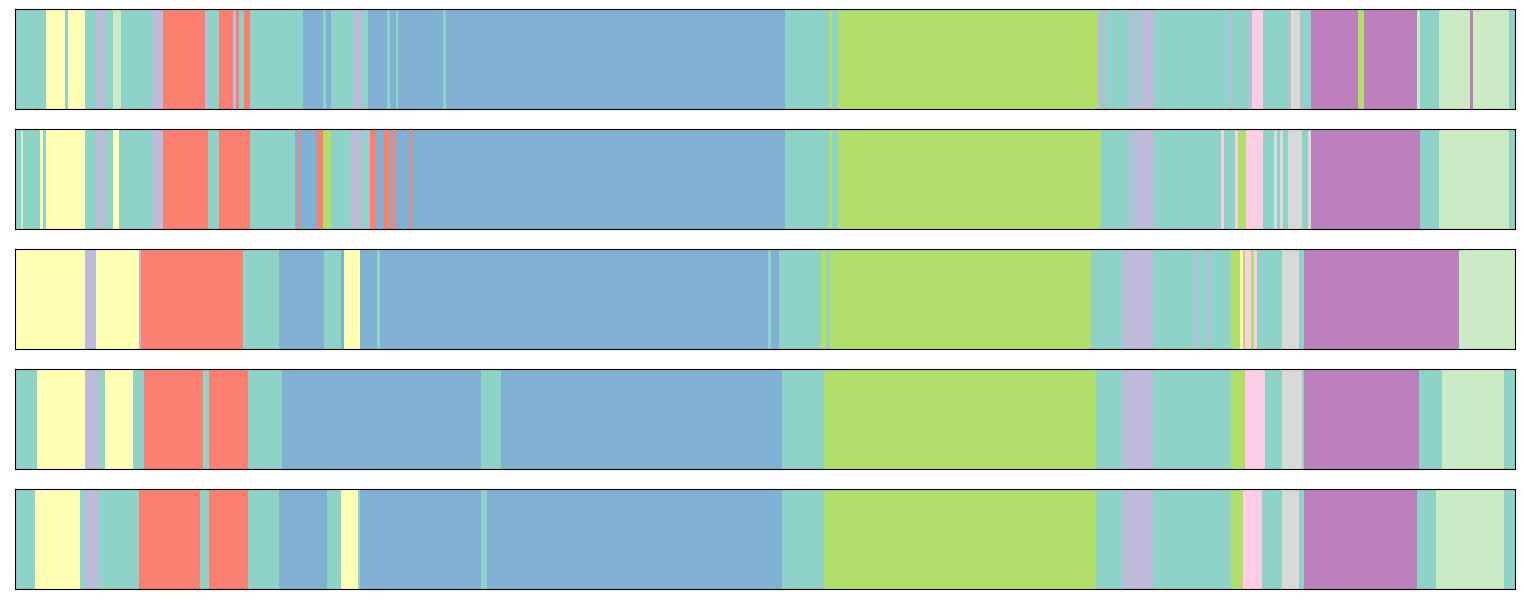

In [244]:
online_result = pd.read_csv("/home/lxj/project/surgplan/LUO/result_real_time_test20.mp4.csv")
online_result = online_result["pred_labels"]

_barcode(df_gt["gt_labels"],trans_result_2,predict_trans=tecno_result_2,slowfast = online_result,predict_ours=df_pred["pred_labels"],save_file=None,color_map=plt.cm.Set3)


In [246]:
#处理 TransSV


with open("/home/lxj/project/Trans-SVNet/result/result_epoch_37.json","r") as f:
    trans_pred = json.load(f)

In [247]:
gt = pd.read_csv("/home/lxj/project/surgplan/LUO/test_only/TriDet/df_gt.csv")


In [100]:
len(trans_pred)

14857

In [248]:
trans_result = trans_pred[13816:14338]

In [249]:
#tecno


with open("/home/lxj/project/Trans-SVNet/result_tecno/result_epoch_18.json","r") as f:
    tecno_pred = json.load(f)
    

In [250]:
tecno_result = tecno_pred[13816:14338]

In [255]:
online_result = pd.read_csv("/home/lxj/project/surgplan/LUO/result_real_time_test23.mp4.csv")
online_result = online_result["pred_labels"]

In [177]:
revised_df = df_pred["pred_labels"].copy()

In [205]:
df_gt #+13

,video_id,gt_labels
13803,test23.mp4,0
13804,test23.mp4,0
13805,test23.mp4,0
13806,test23.mp4,0
13807,test23.mp4,0
...,...,...
14320,test23.mp4,18
14321,test23.mp4,0
14322,test23.mp4,0
14323,test23.mp4,0


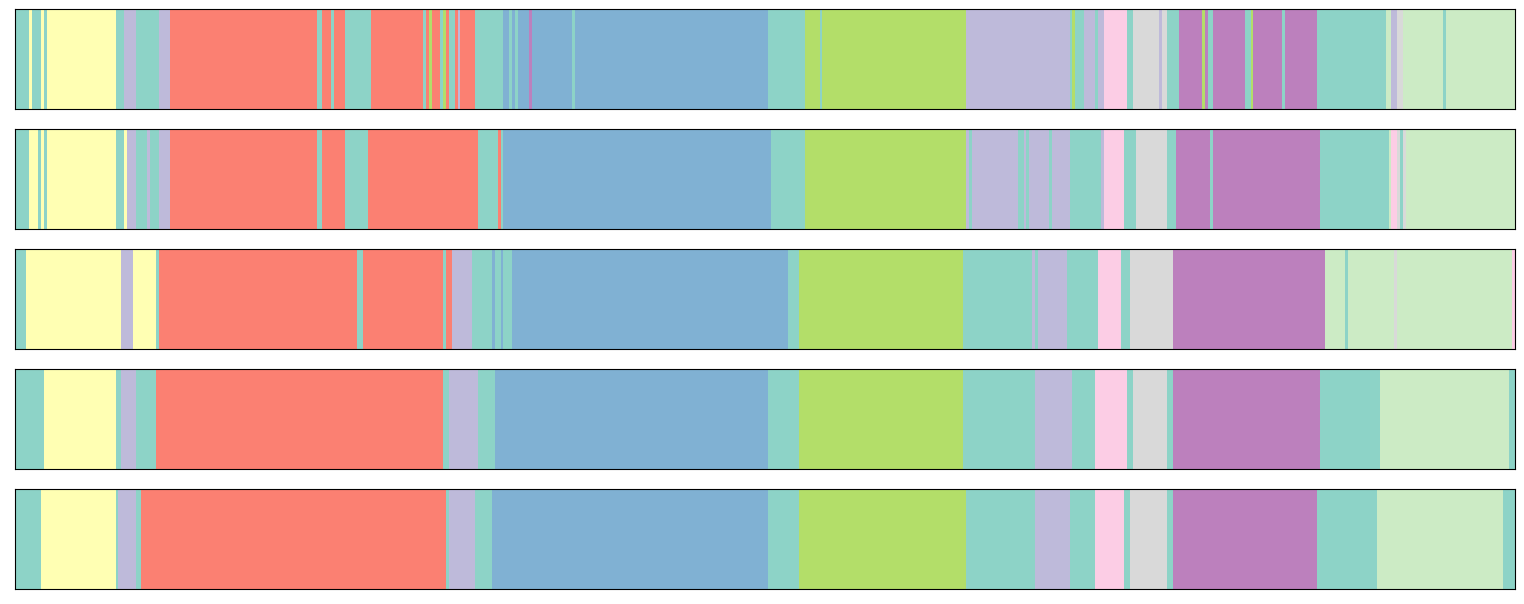

In [256]:
_barcode(df_gt["gt_labels"],trans_result,predict_trans=tecno_result,slowfast = online_result,predict_ours=df_pred["pred_labels"],save_file=None,color_map=plt.cm.Set3)

In [14]:
svrcn = pd.read_csv("/home/pangy/disk/LUO/test_only/TriDet/SVRC-Net.csv")
svrcn_pred = svrcn["pred_labels"]

In [15]:
gt = pd.read_csv("/home/pangy/disk/LUO/test_only/TriDet/df_gt.csv")


In [16]:
vid_counts = gt.groupby("video_id").count()

In [17]:
int(vid_counts.iloc[0])

754

In [18]:
import torch

dir_path = "/home/pangy/disk/LUO/test_only/TriDet/slowfast_pred"
file_list = os.listdir(dir_path)
file_list.sort()
gt = pd.read_csv("/home/pangy/disk/LUO/test_only/TriDet/df_gt.csv")
s = torch.nn.Sigmoid()
sf_pred = []
for i,f in enumerate(file_list):
    file_path = os.path.join(dir_path,f)
    vid_length = int(vid_counts.iloc[i])
    feat = torch.load(file_path)
    feat_used = feat[:vid_length]
    feat_softmax = s(feat_used)
    slowfast_pred = []
    for i in feat_softmax:
        if max(i)<0.015:
            sf_pred.append(0)
        else:
            sf_pred.append(int(i.argmax()))
    #sf_pred.append(slowfast_pred)



In [21]:
#slowfast feature
sf_feat = torch.load("/home/pangy/disk/LUO/test_only/TriDet/out_cls_logits.pkl")
sf_feat_used = sf_feat[0][0][:504]
s = torch.nn.Sigmoid()
sf_feat_used_softmax = s(sf_feat_used)
sf_feat_used_softmax = sf_feat_used_softmax.to("cpu")
slowfast_pred = []
for i in sf_feat_used_softmax:
    if max(i)<0.02:
        slowfast_pred.append(0)
    else:
        slowfast_pred.append(int(i.argmax()))


In [27]:
df_pred

,video_id,gt_labels
2611,test03.mp4,0
2612,test03.mp4,0
2613,test03.mp4,0
2614,test03.mp4,0
2615,test03.mp4,0
...,...,...
3109,test03.mp4,18
3110,test03.mp4,0
3111,test03.mp4,0
3112,test03.mp4,0


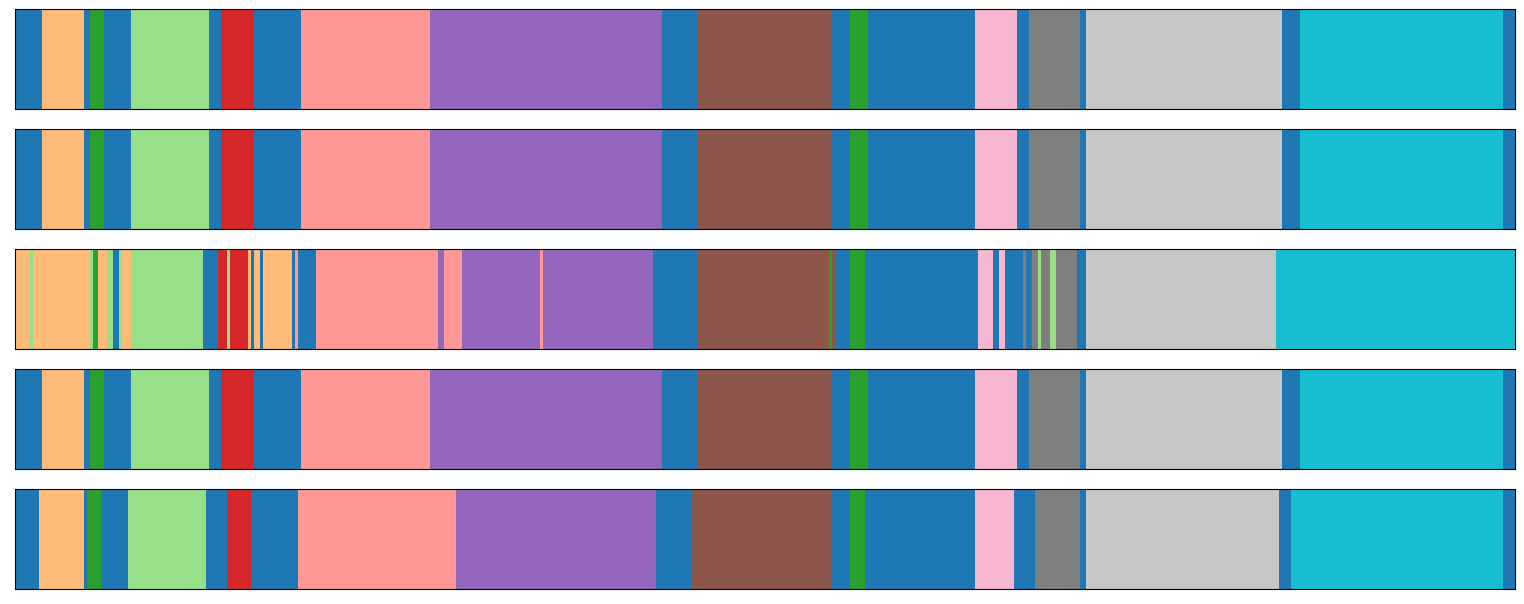

In [35]:
_barcode(df_gt["gt_labels"],df_pred["pred_labels"],predict_trans=df_pred["pred_labels"],slowfast = online_result,predict_ours=df_pred["pred_labels"],save_file=None)

In [23]:
"""for threshold in threshold_list:
    pred_df_threshold = pred_df[pred_df["score"]>threshold]
    print("current threshold: ",threshold,end="     ")
    calculate_acc(pred_df_threshold)
    print("=======================================================================")"""

'for threshold in threshold_list:\n    pred_df_threshold = pred_df[pred_df["score"]>threshold]\n    print("current threshold: ",threshold,end="     ")\n    calculate_acc(pred_df_threshold)\n    print("=======================================================================")'

In [24]:
gt = df_gt["gt_labels"]
predict_phasenet = pred_list
color_map = plt.cm.tab20 # 色板
barprops = dict(aspect='auto', cmap=color_map,
                interpolation='nearest', vmin=0, vmax=20)
num_to_label = { 
    0:"background",
    1:'Toric Marking',
    2:'Implant Ejection', 
    3:'Incision', 
    4:'Viscodilatation', 
    5:'Capsulorhexis', 
    6:'Hydrodissetion',
    7:'Nucleus Breaking', 
    8:'Phacoemulsification', 
    9:'Vitrectomy', 
    10:'Irrigation/Aspiration', 
    11:'Preparing Implant',
    12:'Manual Aspiration', 
    13:'Implantation', 
    14:'Positioning', 
    15:'OVD Aspiration', 
    16:'Suturing', 
    17:'Sealing Control',
    18:'Wound Hydratation'}
#plt.axis('off')
fig = plt.figure(figsize=(15, 10))
# a horizontal barcode
if gt is not None:
    ax1 = fig.add_axes([0, 0.44, 1, 0.1])
    #ax1.set_title('Ground Truth',fontsize=34)
    ax1.set_xticks([])
    ax1.set_yticks([])
    #labels = sorted(df_gt["gt_labels"].unique())  
    #patches = [mpatches.Patch(color=color_map(i)) for i in labels]
    #ax1.legend(labels = [num_to_label[i] for i in labels],handles=patches, loc='upper left', bbox_to_anchor=(1, 1))
    ax1.imshow([gt], **barprops)

if predict_phasenet is not None:
    ax2 = fig.add_axes([0, 0.80, 1, 0.1])
    #ax2.set_title('TeCNO',fontsize=34)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.imshow([predict_phasenet], **barprops)

NameError: name 'pred_list' is not defined

2611     0
2612     0
2613     0
2614     0
2615     0
        ..
3109    18
3110     0
3111     0
3112     0
3113     0
Name: gt_labels, Length: 503, dtype: int64

0.6719681908548708 0.7273204074302738 0.7998258618298157 0.797685267969733


In [ ]:
'''
df_gt= pd.DataFrame(columns=["video_id","gt_labels"])
for k,v in gt_json.items():
    if "train" in k:
        continue
    dur = v["last_time"]
    video_name = k.split(".")[0]
    gt_labels = [0 for i in range(int(np.round(dur)))]
    video_id = [k for i in range(int(np.round(dur)))]
    df = pd.DataFrame(columns=["video_id","gt_labels"])
    df["video_id"] = video_id
    df["gt_labels"] = gt_labels
    subset = gt_df[gt_df["video-id"]==video_name]
    
    for index in subset.index:
        start = int(np.round(subset.loc[index]["t-start"]))
        end = int(np.round(subset.loc[index]["t-end"]))
        label = subset.loc[index]["label"]
        for i in range(start,end+1):
            df.loc[i,"gt_labels"] = label+1
    
    df_gt = pd.concat([df_gt,df],ignore_index=True)
        
df_pred = pd.DataFrame(columns=["video_id","pred_labels"])
for k,v in gt_json.items():
    if "train" in k:
        continue
    video_name = k.split(".")[0]
    dur = v["last_time"]
    gt_labels = [0 for i in range(int(np.round(dur)))]
    video_id = [k for i in range(int(np.round(dur)))]
    df = pd.DataFrame(columns=["video_id","pred_labels"])
    df["video_id"] = video_id
    df["pred_labels"] = gt_labels
    subset = pred_df[pred_df["video-id"]==video_name]
    
    for index in subset.index:
        start = int(np.round(subset.loc[index]["t-start"]))
        end = int(np.round(subset.loc[index]["t-end"]))
        label = subset.loc[index]["label"]
        for i in range(start,end+1):
            if i>=len(df):
                continue
            df.loc[i,"pred_labels"] = label+1
    #print(df)
    df_pred = pd.concat([df_pred,df],ignore_index=True)


df_all =pd.concat([df_gt,df_pred["pred_labels"]],axis=1)     
accuracy_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list())      
'''

'\ndf_gt= pd.DataFrame(columns=["video_id","gt_labels"])\nfor k,v in gt_json.items():\n    if "train" in k:\n        continue\n    dur = v["last_time"]\n    video_name = k.split(".")[0]\n    gt_labels = [0 for i in range(int(np.round(dur)))]\n    video_id = [k for i in range(int(np.round(dur)))]\n    df = pd.DataFrame(columns=["video_id","gt_labels"])\n    df["video_id"] = video_id\n    df["gt_labels"] = gt_labels\n    subset = gt_df[gt_df["video-id"]==video_name]\n    \n    for index in subset.index:\n        start = int(np.round(subset.loc[index]["t-start"]))\n        end = int(np.round(subset.loc[index]["t-end"]))\n        label = subset.loc[index]["label"]\n        for i in range(start,end+1):\n            df.loc[i,"gt_labels"] = label+1\n    \n    df_gt = pd.concat([df_gt,df],ignore_index=True)\n        \ndf_pred = pd.DataFrame(columns=["video_id","pred_labels"])\nfor k,v in gt_json.items():\n    if "train" in k:\n        continue\n    video_name = k.split(".")[0]\n    dur = v["la

In [3]:
df = pd.read_csv("/data/disk/LUO/test_only/r_tridet/TriDet/gt_pred_df.csv")

array(['test01.mp4', 'test02.mp4', 'test03.mp4', 'test04.mp4',
       'test05.mp4', 'test06.mp4', 'test07.mp4', 'test08.mp4',
       'test09.mp4', 'test10.mp4', 'test11.mp4', 'test12.mp4',
       'test13.mp4', 'test14.mp4', 'test15.mp4', 'test16.mp4',
       'test17.mp4', 'test18.mp4', 'test19.mp4', 'test20.mp4',
       'test21.mp4', 'test22.mp4', 'test23.mp4', 'test24.mp4',
       'test25.mp4'], dtype=object)

In [20]:
for i in df["video_id"].unique():
    print(i)
    test = df[df["video_id"]==i]
    print(accuracy_score(test["gt_labels"],test["pred_labels"]))

test01.mp4
0.8076923076923077
test02.mp4
0.4991922455573506
test03.mp4
0.9403578528827038
test04.mp4
0.9173553719008265
test05.mp4
0.8891257995735607
test06.mp4
0.9187279151943463
test07.mp4
0.6711538461538461
test08.mp4
0.9548532731376975
test09.mp4
0.8604651162790697
test10.mp4
0.926056338028169
test11.mp4
0.8949416342412452
test12.mp4
0.9539641943734015
test13.mp4
0.935251798561151
test14.mp4
0.9238578680203046
test15.mp4
0.9504132231404959
test16.mp4
0.7756598240469208
test17.mp4
0.884765625
test18.mp4
0.8011444921316166
test19.mp4
0.8894952251023193
test20.mp4
0.9250936329588015
test21.mp4
0.9168399168399168
test22.mp4
0.8036437246963563
test23.mp4
0.9578544061302682
test24.mp4
0.9496124031007752
test25.mp4
0.9120135363790186


0.4991922455573506

In [4]:
test01 = pd.read_csv("/home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/2024-02-01-07-09-42_result/result_real_time_test01.mp4.csv")

In [37]:
test03 = pd.read_csv("/data/disk/LUO/test_only/r_tridet/TriDet/2024-02-01-07-09-42_result/result_real_time_test03.mp4.csv")

In [36]:
print(accuracy_score(test01["gt_labels"][:13],test01["pred_labels"][-13:]))

0.8461538461538461


In [38]:
print(accuracy_score(test03["gt_labels"][:],test03["pred_labels"][:]))

0.8588469184890656
